In [ ]:
pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avkrylovv","key":"052e90e6d6225e0650f1e999540f4ec8"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d ananthr1/weather-prediction

  0% 0.00/11.5k [00:00<?, ?B/s]
100% 11.5k/11.5k [00:00<00:00, 22.4MB/s]


In [ ]:
! unzip  '/content/weather-prediction.zip' -d '/content/weather-prediction'

Archive:  /content/weather-prediction.zip
  inflating: /content/weather-prediction/seattle-weather.csv  


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.utils import make_grid
import torch.utils.data as data
from torch.autograd import Variable
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cpu'

In [ ]:
df = pd.read_csv('/content/weather-prediction/seattle-weather.csv')
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [ ]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [ ]:
df2 = df.drop(columns=['precipitation','wind','weather'], axis = 1)
df2.head()

,date,temp_max,temp_min
0,2012-01-01,12.8,5.0
1,2012-01-02,10.6,2.8
2,2012-01-03,11.7,7.2
3,2012-01-04,12.2,5.6
4,2012-01-05,8.9,2.8


In [ ]:
mean = df2.mean(axis=1)
mean
df3 = pd.concat([df2['date'], mean], axis=1)
df3.head()

<ipython-input-89-15358cfaffd2>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = df2.mean(axis=1)


,date,0
0,2012-01-01,8.90
1,2012-01-02,6.70
2,2012-01-03,9.45
3,2012-01-04,8.90
4,2012-01-05,5.85


In [ ]:
df3 = df3.rename(columns={0:'mean_temp'})
df3.head()

,date,mean_temp
0,2012-01-01,8.90
1,2012-01-02,6.70
2,2012-01-03,9.45
3,2012-01-04,8.90
4,2012-01-05,5.85


<Axes: xlabel='date', ylabel='mean_temp'>

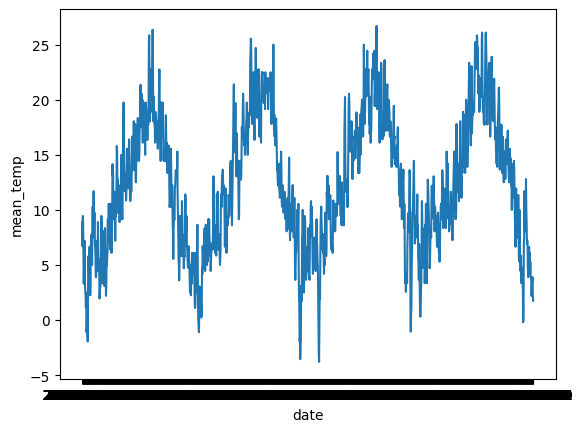

In [ ]:
sns.lineplot(data=df3, x="date", y="mean_temp")

In [ ]:
timeseries = df3[["mean_temp"]].values.astype('float32')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mms = MinMaxScaler()

In [ ]:
timeseries = mms.fit_transform(timeseries)

In [ ]:
train_size = int(len(timeseries)*0.9)
test_size = len(timeseries) - train_size
print(train_size)
print(test_size)
train, test = timeseries[:train_size], timeseries[train_size:]
print(len(train))
print(len(test))

1314
147
1314
147


In [ ]:
def My_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [ ]:
lookback = 4
X_train, y_train = My_dataset(train, lookback=lookback)
X_test, y_test = My_dataset(test, lookback=lookback)

In [ ]:
class WeatherModel(nn.Module):
    def __init__(self):
        super(WeatherModel, self).__init__()
        self.num_layers = 1
        self.hidden_size = 50

        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, _) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.linear(hn)
        return out

In [ ]:
model = WeatherModel().to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=0.1)
criterion = nn.MSELoss()

In [ ]:
batch_size = 8
train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=batch_size,shuffle=True)
test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), batch_size=batch_size,shuffle=True)

In [ ]:
! pip install torchinfo

In [ ]:
!pip install pytorch-ignite --quiet

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix, MeanSquaredError, RootMeanSquaredError
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [ ]:
metrics = { "mse" : MeanSquaredError()}

In [ ]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics,device=device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device=device)

In [ ]:
training_history = {'mse':[]}
test_history = {'mse':[]}
last_epoch = []

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['mse']
    last_epoch.append(0)
    training_history['mse'].append(loss)
    if trainer.state.epoch % 100 == 0:
      print("Результат обучения - Эпоха: {}  ошибка: {:.7f}"
          .format(trainer.state.epoch,loss))

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    loss = metrics['mse']
    test_history['mse'].append(loss)
    if trainer.state.epoch % 100 == 0:
      print("Результат валидации - Эпоха: {}  ошибка: {:.7f}"
          .format(trainer.state.epoch, loss))

In [ ]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="mse",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [ ]:
trainer.run(train_loader, max_epochs=2000)

Результат обучения - Эпоха: 100  ошибка: 0.0036970
Результат валидации - Эпоха: 100  ошибка: 0.0036122
Результат обучения - Эпоха: 200  ошибка: 0.0036298
Результат валидации - Эпоха: 200  ошибка: 0.0035544
Результат обучения - Эпоха: 300  ошибка: 0.0036857
Результат валидации - Эпоха: 300  ошибка: 0.0039583
Результат обучения - Эпоха: 400  ошибка: 0.0035667
Результат валидации - Эпоха: 400  ошибка: 0.0038680
Результат обучения - Эпоха: 500  ошибка: 0.0034227
Результат валидации - Эпоха: 500  ошибка: 0.0035585
Результат обучения - Эпоха: 600  ошибка: 0.0034678
Результат валидации - Эпоха: 600  ошибка: 0.0038399
Результат обучения - Эпоха: 700  ошибка: 0.0033589
Результат валидации - Эпоха: 700  ошибка: 0.0037796
Результат обучения - Эпоха: 800  ошибка: 0.0033509
Результат валидации - Эпоха: 800  ошибка: 0.0039837
Результат обучения - Эпоха: 900  ошибка: 0.0032598
Результат валидации - Эпоха: 900  ошибка: 0.0038361
Результат обучения - Эпоха: 1000  ошибка: 0.0032210
Результат валидации -

State:
	iteration: 328000
	epoch: 2000
	epoch_length: 164
	max_epochs: 2000
	output: 0.005138649605214596
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))
print("Модель загружена")

Модель загружена


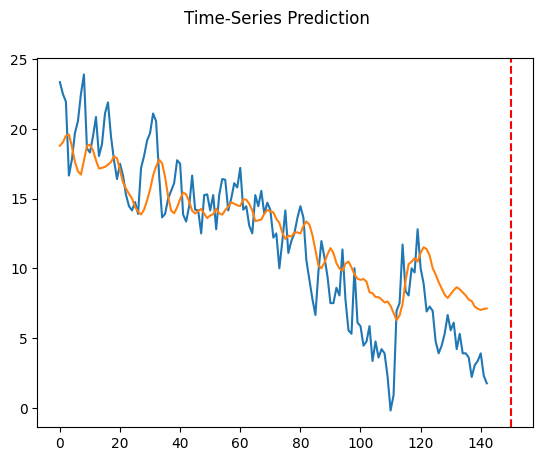

In [ ]:
train_predict = model(X_test)

data_predict = train_predict.data.numpy()
dataY_plot = y_test.data.numpy()

data_predict = mms.inverse_transform(data_predict)
dataY_plot = mms.inverse_transform(dataY_plot)

plt.axvline(x=150, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()